# STATISTICAL LEARNING PROJECT:

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

import seaborn as sns


In [247]:
# carico il dataset e stampo l'head
df= pd.read_csv("f1_pitstops_2018_2024.csv")

df.head()

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,Race Name,...,Tire Usage Aggression,Fast Lap Attempts,Position Changes,Driver Aggression Score,Abbreviation,Stint,Tire Compound,Stint Length,Pit_Lap,Pit_Time
0,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,1.0,ULTRASOFT,25.0,26.0,21.787
1,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,2.0,SOFT,32.0,NaN,Final Stint
2,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,1.0,ULTRASOFT,17.0,19.0,21.821
3,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,2.0,SOFT,39.0,NaN,Final Stint
4,2018,1,Albert Park Grand Prix Circuit,Kimi RÃƒÂ¤ikkÃƒÂ¶nen,Ferrari,58,3,1,21.421,Australian Grand Prix,...,0.017241,45.13482,0.086957,6.818562,RAI,1.0,ULTRASOFT,17.0,18.0,21.421


In [248]:
df.columns

Index(['Season', 'Round', 'Circuit', 'Driver', 'Constructor', 'Laps',
       'Position', 'TotalPitStops', 'AvgPitStopTime', 'Race Name', 'Date',
       'Time_of_race', 'Location', 'Country', 'Air_Temp_C', 'Track_Temp_C',
       'Humidity_%', 'Wind_Speed_KMH', 'Lap Time Variation', 'Total Pit Stops',
       'Tire Usage Aggression', 'Fast Lap Attempts', 'Position Changes',
       'Driver Aggression Score', 'Abbreviation', 'Stint', 'Tire Compound',
       'Stint Length', 'Pit_Lap', 'Pit_Time'],
      dtype='object')

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   7374 non-null   int64  
 1   Round                    7374 non-null   int64  
 2   Circuit                  7374 non-null   object 
 3   Driver                   7374 non-null   object 
 4   Constructor              7374 non-null   object 
 5   Laps                     7374 non-null   int64  
 6   Position                 7374 non-null   int64  
 7   TotalPitStops            7374 non-null   int64  
 8   AvgPitStopTime           7189 non-null   float64
 9   Race Name                7001 non-null   object 
 10  Date                     7001 non-null   object 
 11  Time_of_race             7001 non-null   object 
 12  Location                 7001 non-null   object 
 13  Country                  7001 non-null   object 
 14  Air_Temp_C              

In [250]:
# Let's look at basic statistics
print(df.describe())


            Season        Round         Laps     Position  TotalPitStops  \
count  7374.000000  7374.000000  7374.000000  7374.000000    7374.000000   
mean   2021.308245    10.673312    56.643748    10.156089       2.068348   
std       1.969604     6.135126    13.922667     5.590062       1.135088   
min    2018.000000     1.000000     0.000000     1.000000       0.000000   
25%    2020.000000     5.000000    52.000000     5.000000       1.000000   
50%    2021.000000    11.000000    57.000000    10.000000       2.000000   
75%    2023.000000    15.000000    66.000000    15.000000       3.000000   
max    2024.000000    24.000000    87.000000    20.000000       7.000000   

       AvgPitStopTime   Air_Temp_C  Track_Temp_C   Humidity_%  Wind_Speed_KMH  \
count     7189.000000  7001.000000   7001.000000  7001.000000     7001.000000   
mean       120.109095    19.520345     25.207104    67.576191       11.434032   
std        268.723688     5.092982      5.195562    14.157319        6.0

## Check if the data contains any missing values

In [251]:
# Controllo i dati nulli
columnsWithNulls=df.isnull().sum().sort_values(ascending=False)
columnsWithNulls=columnsWithNulls[columnsWithNulls>0]
print(columnsWithNulls)

Pit_Lap                    2810
Track_Temp_C                373
Date                        373
Wind_Speed_KMH              373
Humidity_%                  373
Air_Temp_C                  373
Country                     373
Location                    373
Time_of_race                373
Race Name                   373
Pit_Time                    281
AvgPitStopTime              185
Lap Time Variation          185
Driver Aggression Score     185
Fast Lap Attempts           185
Stint Length                109
Tire Compound               109
Stint                       109
Tire Usage Aggression        66
dtype: int64


In [252]:
# Controllo in percentuale quanti dati mancano così da capire come trattarli, pongo una soglia di eliminazione del regressore nel caso di +30% di dati mancanti
missing_pct = df.isnull().mean() * 100
missing_only = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_only)


Pit_Lap                    38.106862
Wind_Speed_KMH              5.058313
Date                        5.058313
Time_of_race                5.058313
Location                    5.058313
Country                     5.058313
Air_Temp_C                  5.058313
Track_Temp_C                5.058313
Humidity_%                  5.058313
Race Name                   5.058313
Pit_Time                    3.810686
Fast Lap Attempts           2.508815
Driver Aggression Score     2.508815
Lap Time Variation          2.508815
AvgPitStopTime              2.508815
Stint                       1.478167
Tire Compound               1.478167
Stint Length                1.478167
Tire Usage Aggression       0.895037
dtype: float64


In [253]:
#droppiamo le righe con i valori nulli e le colonne con più del 30% di dati nulli
df.dropna(axis=0, inplace=True)
df.drop(columns=missing_only[missing_only>30].index, inplace=True)
df.isnull().sum()


Season                     0
Round                      0
Circuit                    0
Driver                     0
Constructor                0
Laps                       0
Position                   0
TotalPitStops              0
AvgPitStopTime             0
Race Name                  0
Date                       0
Time_of_race               0
Location                   0
Country                    0
Air_Temp_C                 0
Track_Temp_C               0
Humidity_%                 0
Wind_Speed_KMH             0
Lap Time Variation         0
Total Pit Stops            0
Tire Usage Aggression      0
Fast Lap Attempts          0
Position Changes           0
Driver Aggression Score    0
Abbreviation               0
Stint                      0
Tire Compound              0
Stint Length               0
Pit_Time                   0
dtype: int64

## Data Preprocessing

## Correlation HeatMap 

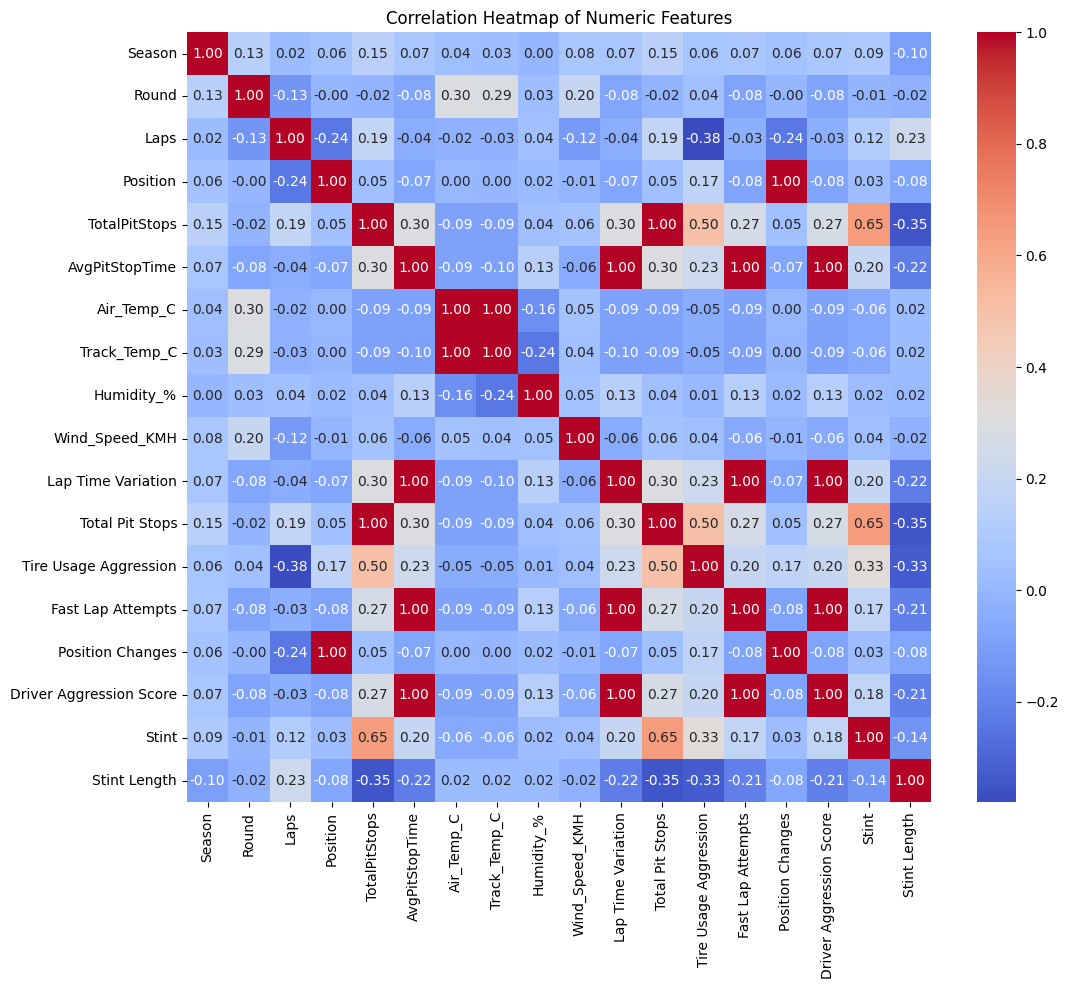

In [254]:
# Generate correlation heatmap for numeric features
numeric_df = df.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')


In [255]:
# 1. Seleziona solo le colonne numeriche e calcola la correlazione assoluta
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr().abs()

# 2. Prendi la metà superiore (senza diagonale)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 3. Trova tutte le colonne con corr > 0.99
to_drop = [col for col in upper.columns if any(upper[col] > 0.99)]
print("Tutte le colonne candidate al drop:", to_drop)

# 4. Rimuovi 'Driver Aggression Score' dalla lista, se presente
to_drop = [col for col in to_drop if col != "Driver Aggression Score"]
print("Colonne da droppare (escl. Driver Aggression Score):", to_drop)

# 5. Droppa solo le restanti
df.drop(columns=to_drop, inplace=True)

# 6. Droppiamo AvgPitStopTime
df.drop(columns=['AvgPitStopTime'], inplace=True)



Tutte le colonne candidate al drop: ['Track_Temp_C', 'Lap Time Variation', 'Total Pit Stops', 'Fast Lap Attempts', 'Position Changes', 'Driver Aggression Score']
Colonne da droppare (escl. Driver Aggression Score): ['Track_Temp_C', 'Lap Time Variation', 'Total Pit Stops', 'Fast Lap Attempts', 'Position Changes']


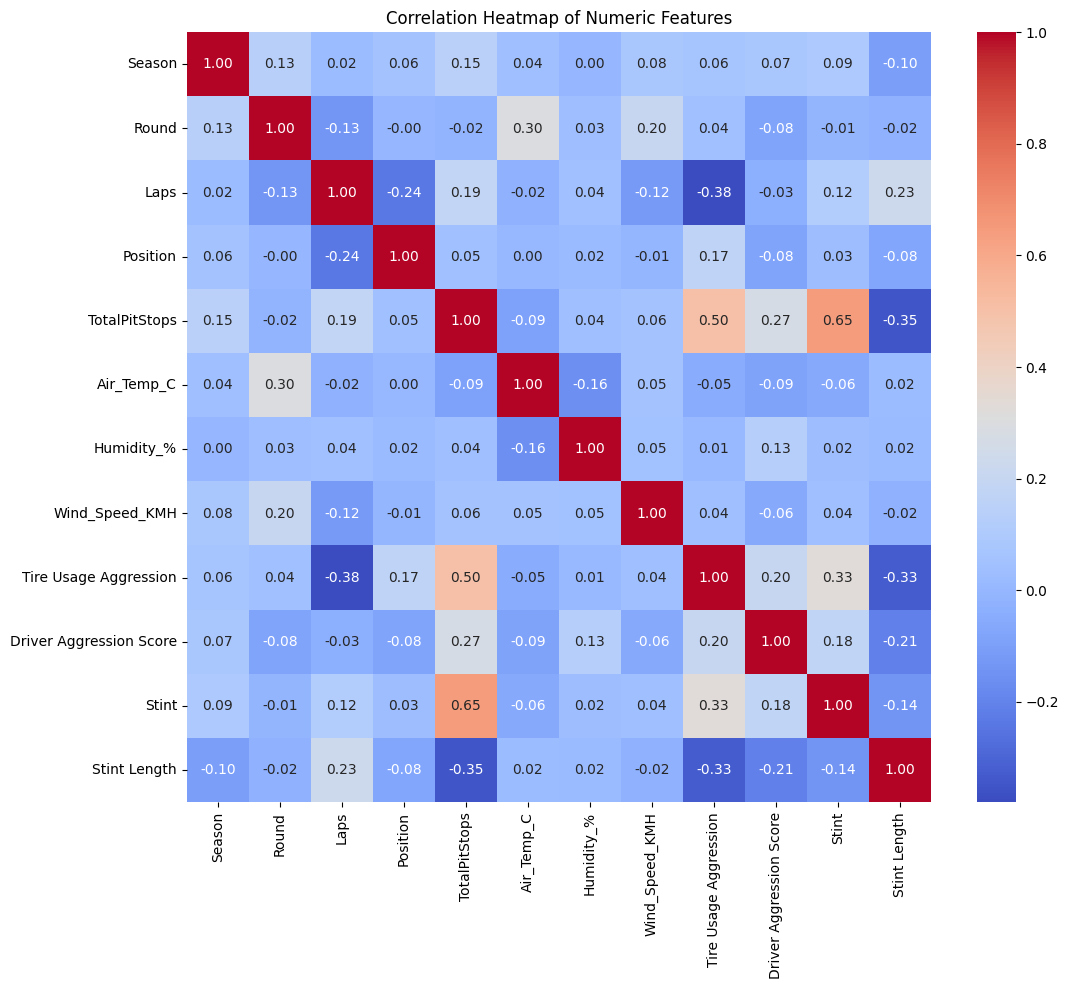

In [256]:
# Generate correlation heatmap for numeric features
numeric_df = df.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')


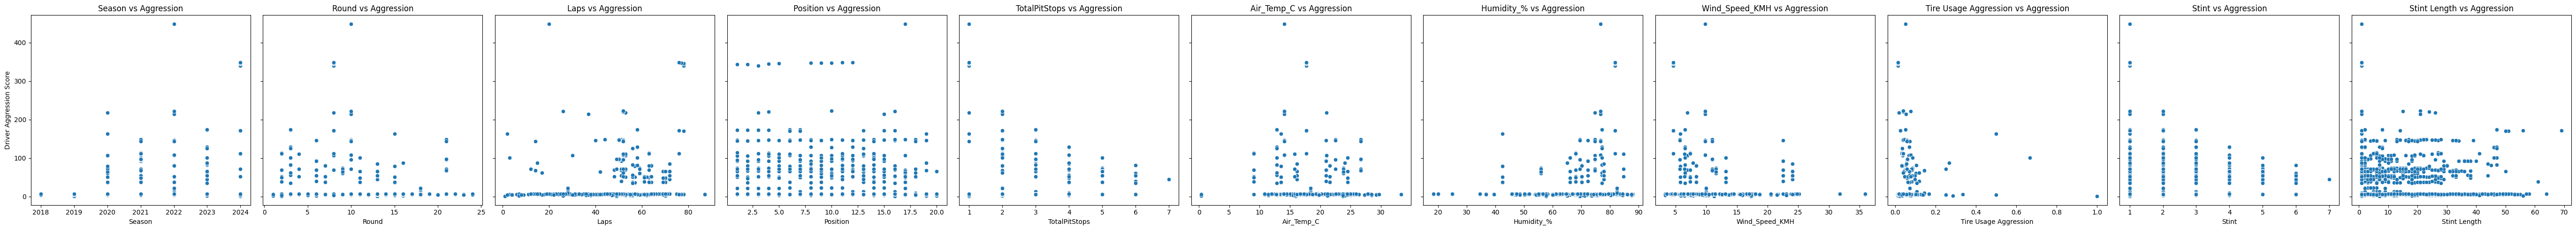

In [257]:
# Seleziona solo le variabili numeriche tranne 'Driver Aggression Score'
numeric_cols = df.select_dtypes(include='number').columns
x_vars = [col for col in numeric_cols if col != 'Driver Aggression Score']

# Imposta il layout della figura
n = len(x_vars)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 5), sharey=True)

# Scatterplot di ogni variabile rispetto al Driver Aggression Score
for i, var in enumerate(x_vars):
    sns.scatterplot(data=df, x=var, y='Driver Aggression Score', ax=axes[i])
    axes[i].set_title(f'{var} vs Aggression')
    axes[i].set_xlabel(var)

axes[0].set_ylabel('Driver Aggression Score')
plt.tight_layout()
plt.show()

## TEST MODELLO LINEARE

In [258]:
X = pd.DataFrame({
    'intercept': np.ones(df.shape[0]),
    'TotalPitStops': df['TotalPitStops'],  # Una delle feature indipendenti
})
X[:4]

,intercept,TotalPitStops
0,1.0,1
2,1.0,1
4,1.0,1
6,1.0,1


In [259]:
y = df['Driver Aggression Score']  # La variabile target
model = sm.OLS(y, X) #function to fit a simple linear regression. Here we define the model
results = model.fit() #here we fit the model

In [260]:
summarize(results) #produces a simple table of the parameter estimates, their standard errors, t-statistics and p-values

,coef,std err,t,P>|t|
intercept,0.4541,1.217,0.373,0.709
TotalPitStops,8.6129,0.471,18.289,0.000


In [261]:
numeric_cols = df.select_dtypes(include='number').columns.drop('Driver Aggression Score')
X = df[numeric_cols]

# 2. Aggiungi la colonna dell'intercetta (bias)
X = sm.add_constant(X)

# 3. Definisci la variabile target
y = df['Driver Aggression Score']

# 4. Crea e adatta il modello
model = sm.OLS(y, X)
results = model.fit()

# 5. Stampa un riepilogo
print(results.summary())

                               OLS Regression Results                              
Dep. Variable:     Driver Aggression Score   R-squared:                       0.139
Model:                                 OLS   Adj. R-squared:                  0.137
Method:                      Least Squares   F-statistic:                     63.28
Date:                     Mon, 21 Apr 2025   Prob (F-statistic):          1.97e-131
Time:                             19:46:49   Log-Likelihood:                -21517.
No. Observations:                     4334   AIC:                         4.306e+04
Df Residuals:                         4322   BIC:                         4.314e+04
Df Model:                               11                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

## interpretazioni

# Var significative
| Variabile               | Coefficiente | Interpretazione                                                                 |
|------------------------|--------------|---------------------------------------------------------------------------------|
| Season                 | +1.0942      | Stagioni più recenti → più aggressività.                                       |
| Round                  | -0.5209      | Avanzando nei round → calo dell’aggressività.                                  |
| Laps                   | -0.3053      | Più giri → tendenza a una guida più gestita e meno aggressiva.                 |
| Position               | -0.9011      | Peggiori posizioni finali → meno aggressività. I migliori sono più aggressivi. |
| TotalPitStops          | +6.6944      | Più pit stop → guida più aggressiva.                                           |
| Humidity_%             | +0.3485      | Maggiore umidità → aumento dell’aggressività.                                  |
| Wind_Speed_KMH         | -0.5068      | Più vento → guida meno aggressiva.                                             |
| Tire Usage Aggression  | +45.6013     | Forte correlazione con l’aggressività (coerenza del nome!).                   |
| Stint Length           | -0.3756      | Stint più lunghi → guida più controllata.                                      |
# Var non significative
| Variabile      | p-value | Interpretazione                                               |
|---------------|---------|---------------------------------------------------------------|
| Air_Temp_C     | 0.353   | La temperatura non ha effetto evidente sull’aggressività.     |
| Stint          | 0.313   | Il numero di stint non risulta avere un impatto chiaro.       |


# risultato diverso dalla heatmap:
La heatmap di correlazione mostra solo relazioni lineari dirette tra variabili, senza tenere conto degli effetti delle altre variabili.

I risultati della regressione lineare (OLS) indicano come le variabili influenzano la variabile target, prendendo in considerazione anche l'effetto delle altre variabili nel modello.

# conclusioni

il valore di R^2 è molto basso usando solo le variabili numeriche, devo provare a usare anche le var categoriche


In [262]:
# Raggruppo le ore per evitare overfitting
df['Hour'] = pd.to_datetime(df['Time_of_race'].str.replace('Z', ''), format='%H:%M:%S').dt.hour

# Creo colonne combinate utili aumentando il rischio di overfit

df['Constructor_Tire'] = df['Constructor'] + ' × ' + df['Tire Compound']
df['Location_Time'] = df['Location'] + ' × ' + df['Hour'].astype(str)
df['Temp_Humidity'] = df['Air_Temp_C'] * df['Humidity_%']

# Controllo il numero di correlazioni che creo, se sono troppo poche sto solo mettendo rumore!
print(df['Constructor_Tire'].nunique()) #105
print(df['Location_Time'].nunique()) #30

# Sono parecchie, così facendo sto quindi aumentando la dimensionalità del modello, dovrò filtrare solo per le correlazioni più frequenti e metto a "Other" le rimanenti

common_constr_tire = df['Constructor_Tire'].value_counts()[df['Constructor_Tire'].value_counts() >= 10].index
df['Constructor_Tire'] = df['Constructor_Tire'].where(df['Constructor_Tire'].isin(common_constr_tire), 'Other')

common_loc_time = df['Location_Time'].value_counts()[df['Location_Time'].value_counts() >= 10].index
df['Location_Time'] = df['Location_Time'].where(df['Location_Time'].isin(common_loc_time), 'Other')

print("\nNuovi valori:")
print(df['Constructor_Tire'].nunique()) #105
print(df['Location_Time'].nunique()) #30


105
40

Nuovi valori:
67
40


In [263]:
from sklearn.discriminant_analysis import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Normalizzazione delle variabili numeriche
numeric_cols = ['Season','Round','Laps','Position','Air_Temp_C','Humidity_%','Wind_Speed_KMH','Temp_Humidity']

# Separaro le variabili numeriche
X_numeric = df[numeric_cols]

# Normalizzo le variabili numeriche
scaler = StandardScaler()
X_numeric_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# 2. Verifico della multicollinearità: Calcolare il VIF
X_vif = sm.add_constant(X_numeric_scaled)

# Calcolo del VIF per ogni variabile (Fattore di Inflazione della Varianza)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Filtro variabili con VIF > 10
print("VIF per ogni variabile:")
print(vif_data)

# Rimuovo le variabili con VIF > 10, se necessario
high_vif = vif_data[vif_data["VIF"] > 10]
print("\nVariabili con VIF alto (maggiore di 10):")
print(high_vif)

VIF per ogni variabile:
         Variable        VIF
0           const   1.000000
1          Season   1.041772
2           Round   1.287634
3            Laps   1.108760
4        Position   1.069647
5      Air_Temp_C  25.796903
6      Humidity_%  17.955852
7  Wind_Speed_KMH   1.062400
8   Temp_Humidity  37.021779

Variabili con VIF alto (maggiore di 10):
        Variable        VIF
5     Air_Temp_C  25.796903
6     Humidity_%  17.955852
8  Temp_Humidity  37.021779


Valuto l'opzione di utilizzare o solo air_temp_C e Humidity% o solo Temp_Humidity

empiricamente decido anche di usare solo Location_Time invece che time e location

In [ ]:
pd.set_option('display.max_rows', None)

# 1. Seleziono solo le colonne numeriche utili alla domanda "cosa influisce sull'aggressività del pilota"
numeric_cols = ['Season','Round','Laps','Position','Wind_Speed_KMH','Air_Temp_C','Humidity_%']

# 2. Seleziono solo le colonne categoriche utili alla domanda "cosa influisce sull'aggressività del pilota"
categorical_cols = ['Circuit', 'Constructor', 'Tire Compound','Constructor_Tire']

# 3. Creo il DataFrame delle variabili numeriche
X_numeric = df[numeric_cols]


# Normalizzo come sopra
scaler = StandardScaler()
X_numeric_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# 4. Creo variabili dummy per le variabili categoriche
X_categorical = pd.get_dummies(df[categorical_cols], drop_first=True)

# 7. Forzo la conversione di tutte le colonne in numerico, se non lo sono già
X = X.apply(pd.to_numeric, errors='coerce')  # forza la conversione a numerico per tutte le colonne

# 8. Mi assicuro che le variabili categoriche siano trattate come numeriche (0 o 1)
X_categorical = X_categorical.astype(int)

# Unisco le variabili categoriche convertite in numerico a X
X = pd.concat([X_numeric, X_categorical], axis=1)

# 9. Aggiungo la colonna dell'intercetta (bias)
X = sm.add_constant(X)

# Mi assicuro che y sia numerico
y = pd.to_numeric(df['Driver Aggression Score'], errors='coerce')

model = sm.OLS(y, X)
results = model.fit()

# 11. Stampo un riepilogo dei risultati
print(results.summary())

# 12. Calcolo e stampo R-squared e Adjusted R-squared
r_squared = results.rsquared
adjusted_r_squared = results.rsquared_adj

print(f'R-squared: {r_squared:.4f}')
print(f'Adjusted R-squared: {adjusted_r_squared:.4f}')

# 13. Trovo le variabili più significative
# Considero variabili con un p-value inferiore a una soglia (ad esempio 0.05)
significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

# 14. Trovo variabili con p-value molto alti per una possibile rimozione
insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)

                               OLS Regression Results                              
Dep. Variable:     Driver Aggression Score   R-squared:                       0.278
Model:                                 OLS   Adj. R-squared:                  0.258
Method:                      Least Squares   F-statistic:                     13.54
Date:                     Mon, 21 Apr 2025   Prob (F-statistic):          1.65e-215
Time:                             19:46:49   Log-Likelihood:                -21134.
No. Observations:                     4334   AIC:                         4.251e+04
Df Residuals:                         4213   BIC:                         4.328e+04
Df Model:                              120                                         
Covariance Type:                 nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [ ]:

# 15. Rimuovo le variabili insignificanti dal DataFrame X
insignificant_cols = insignificant_vars.index
X_reduced = X.drop(columns=insignificant_cols)

# 16. Riprovo a fare la regressione con il nuovo set di variabili
model_reduced = sm.OLS(y, X_reduced)
results_reduced = model_reduced.fit()

# 17. Stampo un riepilogo dei risultati del nuovo modello
print(results_reduced.summary())

# 18. Calcolo e stampo R-squared e Adjusted R-squared per il nuovo modello
r_squared_reduced = results_reduced.rsquared
adjusted_r_squared_reduced = results_reduced.rsquared_adj

print(f'R-squared (modello ridotto): {r_squared_reduced:.4f}')
print(f'Adjusted R-squared (modello ridotto): {adjusted_r_squared_reduced:.4f}')


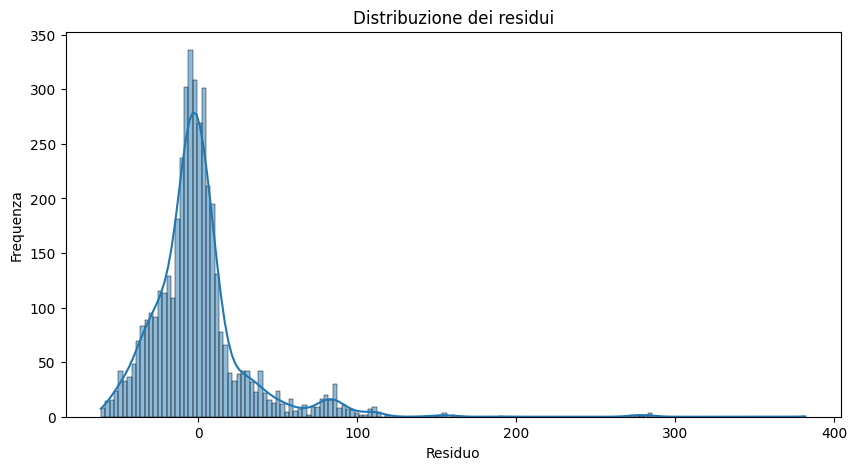

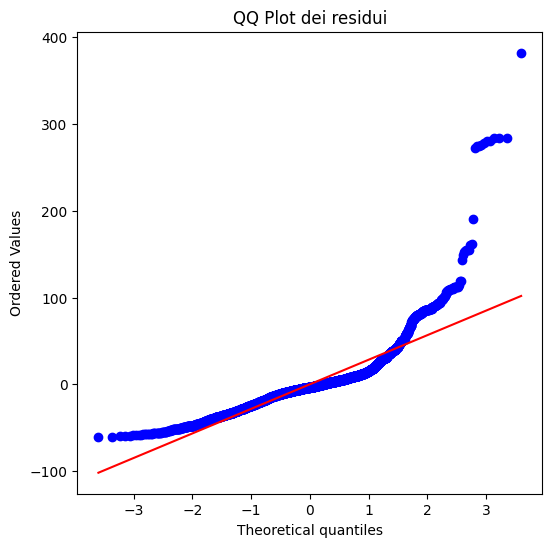

In [265]:
# Residui del modello
from scipy import stats


residuals = results.resid

# Istogramma + distribuzione normale
plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True)
plt.title('Distribuzione dei residui')
plt.xlabel('Residuo')
plt.ylabel('Frequenza')
plt.show()

# QQ Plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot dei residui')
plt.show()

# Autocorrelazione dei residui

In [266]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw:.4f}')

Durbin-Watson statistic: 0.2250


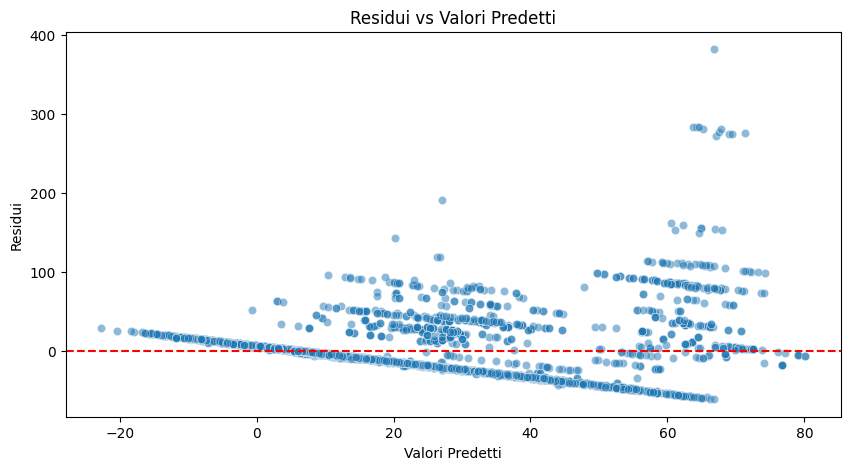

In [267]:
fitted_vals = results.fittedvalues

plt.figure(figsize=(10,5))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')
plt.title('Residui vs Valori Predetti')
plt.show()